In [1]:
%load_ext autoreload
%autoreload 2

# EDA on large sequence-based dataset

In [2]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib import font_manager
import RNA
from common import set_theme

set_theme()

PALETTE = 'viridis'

np.random.seed(0)

from evoscaper.utils.visualise import create_network_inset, make_nx_weights

top_write_dir = os.path.join('data', '24_eda2')

In [ ]:
dir_sim = 'data/simulate_circuits/2025_09_23__15_41_51'

if 'analytics.json' not in os.listdir(dir_sim):
    import jax
    from functools import partial
    from evoscaper.utils.simulation import compute_analytics

    jax.config.update('jax_platform_name', 'cpu')

    n_species = 3
    ys = np.load(os.path.join(dir_sim, 'ys.npy'))
    ts = np.load(os.path.join(dir_sim, 'ts.npy'))
    signal_onehot = np.zeros(ys.shape[-1])
    signal_onehot[-n_species] = 1 

    analytics = jax.vmap(partial(compute_analytics, t=ts, labels=np.arange(
        ys.shape[-1]), signal_onehot=signal_onehot))(ys)
    analytics = {k: np.array(v) for k, v in analytics.items()}

    analytics = {k: v.tolist() for k, v in analytics.items()}
    fn_analytics = os.path.join(dir_sim, 'analytics.json')
    with open(fn_analytics, 'w') as f:
        json.dump(analytics, f, indent=4)
else:
    fn_analytics = os.path.join(dir_sim, 'analytics.json')
    with open(fn_analytics, 'r') as f:
        analytics = json.load(f)

xla_bridge.py:backends():900: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA INFO
xla_bridge.py:backends():900: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory INFO


In [ ]:
fn_circuits = '../data/raw/generate_sequence_batch/2025_09_20_103744/circuits/rc.json'
fn_energies = '../data/raw/generate_sequence_batch/2025_09_20_103744/energies.json'


with open(fn_circuits, 'r') as f:
    circuits = json.load(f)
with open(fn_energies, 'r') as f:
    energies = json.load(f)

In [6]:
cols_e = [f'$RNA_{i+1}$-$RNA_{j+1}$' for i, j in zip(*np.triu_indices(3))]
energy_keys = sorted(energies.keys(), key=lambda k: int(k.split('_')[1]))

# gather all sequence indices present and determine array width
all_indices = {int(idx) for d in energies.values() for idx in d.keys()}
max_idx = max(all_indices) if all_indices else -1
n_seq = max_idx + 1
n_circuits = len(energy_keys)

# allocate and fill array (missing entries default to 0.0)
energies_arr = np.zeros((n_circuits, n_seq), dtype=float)
for i, k in enumerate(energy_keys):
    ed = energies[k]
    for idx_str, val in ed.items():
        energies_arr[i, int(idx_str)] = float(val)
energies_arr = energies_arr.T

n_species_input = len(circuits.keys())
n_species_bound = len(np.triu_indices(n_species_input)[0])
n_species = n_species_input + n_species_bound

print("energies_arr.shape =", energies_arr.shape)
print("sample (first circuit, first 10):", energies_arr[0, :10])


energies_arr.shape = (1000000, 6)
sample (first circuit, first 10): [0. 0. 0. 0. 0. 0.]


# Visualise distributions

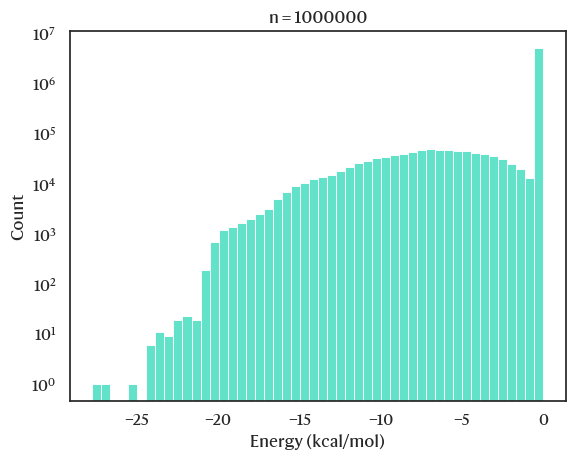

In [10]:
sns.histplot(energies_arr.flatten(), bins=50, color='#2ed9b7')
plt.yscale('log')
plt.xlabel('Energy (kcal/mol)')
plt.title(f'n = {energies_arr.shape[0]}')
plt.savefig(os.path.join(top_write_dir, 'energies_histogram_combined.png'), dpi=300)

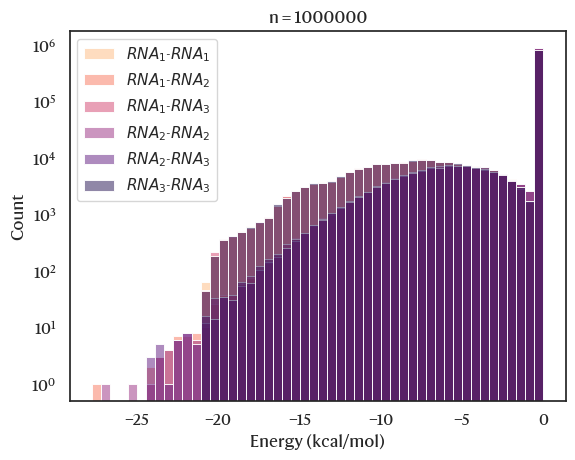

In [11]:
sns.histplot(energies_arr, bins=50, palette='magma')
plt.legend(cols_e)
plt.yscale('log')
plt.xlabel('Energy (kcal/mol)')
plt.title(f'n = {energies_arr.shape[0]}')
plt.savefig(os.path.join(top_write_dir, 'energies_histogram.png'), dpi=300)

/tmp/ipykernel_2515965/558205788.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(pd.DataFrame((energies_arr < 0).sum(axis=1)).value_counts(


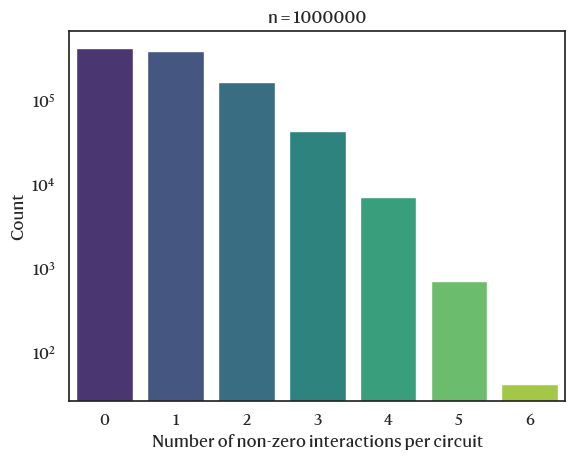

In [9]:
sns.barplot(pd.DataFrame((energies_arr < 0).sum(axis=1)).value_counts(
    ).reset_index().rename(columns={0: 'Number of non-zero interactions per circuit',
                                    'count': 'Count'}), 
            x='Number of non-zero interactions per circuit',
            y='Count', palette=PALETTE)
plt.yscale('log')
plt.title(f'n = {energies_arr.shape[0]}')
plt.savefig(os.path.join(top_write_dir, 'num_nonzero_interactions_per_circuit.png'), dpi=300)

# UMAP

In [16]:
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
analytics['adaptation'] = calculate_adaptation(np.array(analytics['sensitivity']), np.array(analytics['precision']), alpha=2)
analytics['adaptation'].shape


(1000000, 9)

In [ ]:
df = pd.DataFrame(energies_arr, columns=cols_e)
idx_output = -1
df['adaptation'] = np.array(analytics['adaptation'])[..., idx_output]

In [18]:
import umap
from sklearn.preprocessing import StandardScaler


def latin_hypercube_sampling(num_params, param_bounds, num_samples=1000):
    samples = np.zeros((num_samples, num_params))
    for i, (lower, upper) in enumerate(param_bounds):
        samples[:, i] = np.random.uniform(lower, upper, num_samples)
    for j in range(num_params):
        np.random.shuffle(samples[:, j])
    return samples

def reduce_dimensionality(df, n_components=2):
    X = df.values
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    np.random.seed(2)
    reducer = umap.UMAP(n_components=n_components,
                        n_neighbors=40,
                        init='pca',
                        min_dist=0.1,
                        n_jobs=16,
                        n_epochs=50)
    X_reduced = reducer.fit_transform(X_scaled.astype(np.float32))
    
    df['UMAP 1'] = X_reduced[:, 0]
    df['UMAP 2'] = X_reduced[:, 1]
    return df

# Create and run analysis
# filt_d = (df['sample_name'] == 'RNA_2') # & (df['Log sensitivity'] > -5) & (df['Log sensitivity'] < 3) & (~df['Log precision'].isna())
# results = df[filt_d][cols_e] #.iloc[:10000]
results = df[cols_e]
reduced_results = reduce_dimensionality(results)
clustered_results = reduced_results

In [21]:
for k in ['sensitivity', 'precision', 'adaptation']:
    clustered_results[k] = np.array(analytics[k])[..., idx_output]
for k in ['sensitivity', 'precision']:
    clustered_results[f'Log {k}'] = np.log10(clustered_results[k])
n_bins = 20
for k in ['Log sensitivity', 'adaptation']:
    if f'{k} bin' not in clustered_results:
        clustered_results[f'{k} bin'] = pd.cut(clustered_results[k], bins=n_bins)
        clustered_results[f'{k} bin'] = clustered_results[f'{k} bin'].apply(lambda x: np.round(x.mid, 1)).astype(float)

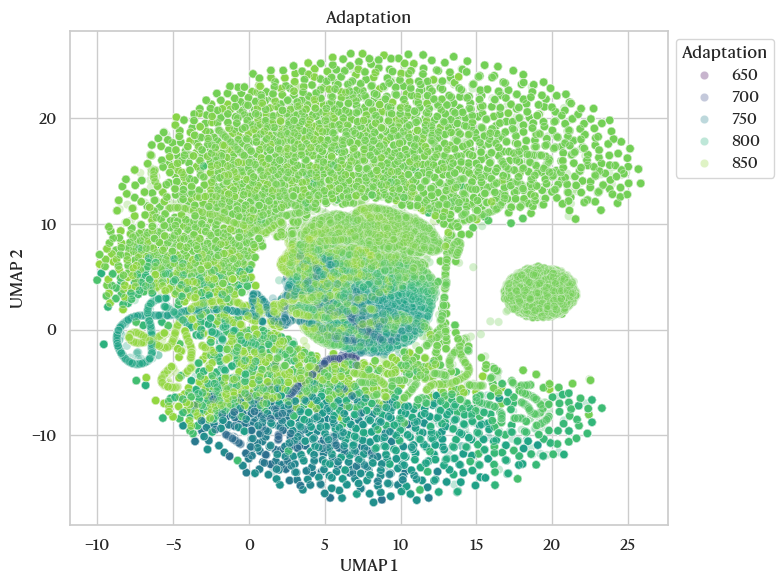

/tmp/ipykernel_2515965/358183811.py:22: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


<Figure size 800x600 with 0 Axes>

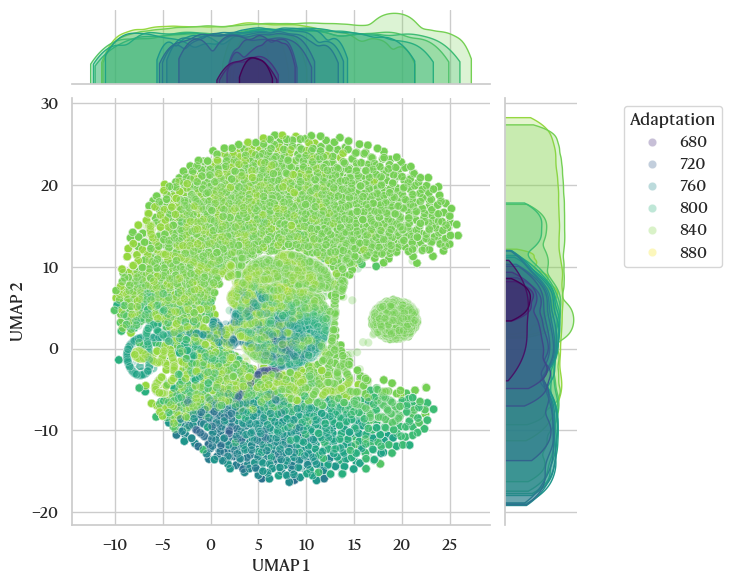

In [30]:
k = 'adaptation'
for plot_set in ['scatter', 'joint']:
    
    hue = f'{k} bin' if plot_set == 'joint' else k
    title = k.capitalize().replace('Log', f'$Log_{{10}}$')
    f = sns.jointplot if plot_set == 'joint' else sns.scatterplot
    
    fig = plt.figure(figsize=(8, 6))
    g = f(clustered_results, x='UMAP 1', y='UMAP 2', hue=hue, palette='viridis', alpha=0.3)
    if plot_set == 'scatter': plt.title(title)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    sns.move_legend(g.ax_joint if plot_set == 'joint' else g, 'upper left', 
                    bbox_to_anchor=(1.3, 1) if plot_set == 'joint' else (1, 1), title=title)
    
    if plot_set == 'joint':
        # Set log scale on the *marginal histograms*
        g.ax_marg_x.set_yscale("log")  # horizontal histogram (log on count axis)
        g.ax_marg_y.set_xscale("log")  # vertical histogram
        g.ax_joint.set_alpha(0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(top_write_dir, f'{plot_set}_umap_adaptation.png'), dpi=300, transparent=True)
    # plt.savefig(os.path.join(top_write_dir, f'{plot_set}_umap_sensitivity.svg'))
    plt.show()

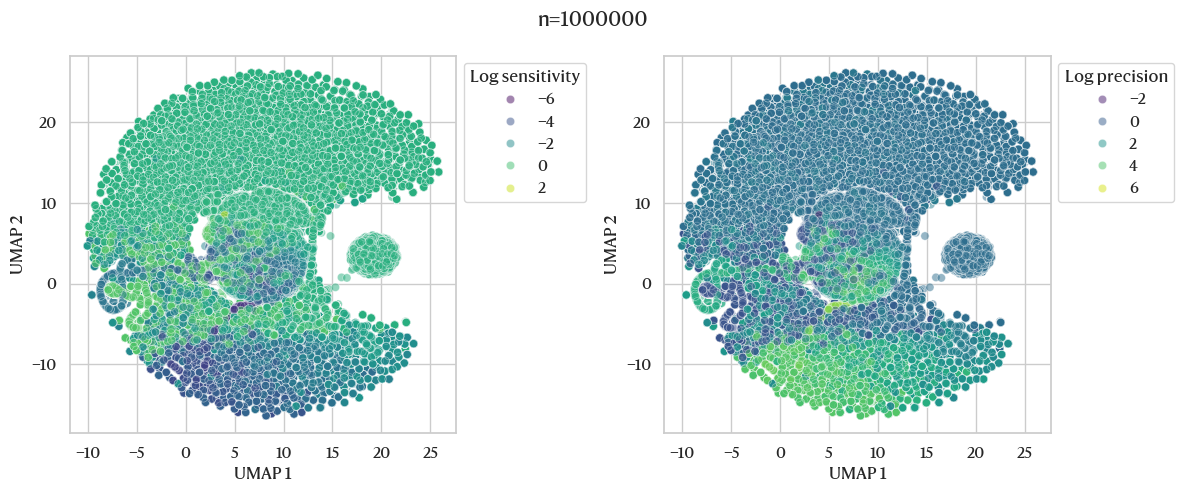

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, k in enumerate(['Log sensitivity', 'Log precision']):
    ax = axs[i]
    g = sns.scatterplot(clustered_results[np.abs(clustered_results[k]) < np.inf], 
                        x='UMAP 1', y='UMAP 2', alpha=0.5,
                        hue=k,
                        ax=ax, palette=PALETTE)
    sns.move_legend(g, 'upper left', bbox_to_anchor=(
        1, 1), title=k.capitalize())
plt.suptitle(f'n={len(clustered_results)}')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, f'scatter_umap_sensitivity_precision.png'), dpi=300, transparent=True)